<a href="https://colab.research.google.com/github/asrivastava0601/TechnoPulse_Competition/blob/master/TechnoPulse_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import AvgPool2D
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import hashlib
from hashlib import md5
import os
import random
import shutil as sh

In [0]:
df1 = pd.read_csv("/content/gdrive/My Drive/Challenge/Trainingcopy.csv")

df1.head()

,file,label
0,1,0
1,2,2
2,3,3
3,4,4
4,5,0


In [0]:
df1['path1'] = 'Image-'

df1['jpg'] = '.jpg'

df1['Image'] =  df1['path1'] + df1['file'].astype(str) + df1['jpg']
df1 = df1.drop(['file','path1','jpg'], axis = 1)

df1 = df1[['Image','label']]

df1.head()

,Image,label
0,Image-1.jpg,0
1,Image-2.jpg,2
2,Image-3.jpg,3
3,Image-4.jpg,4
4,Image-5.jpg,0


In [0]:
label_count = df1.groupby('label')['Image'].nunique()

print("Class label and Image count\n",label_count)

Class label and Image count
 label
0     892
1     976
2    1044
3    1101
4    1206
Name: Image, dtype: int64


In [0]:
os.getcwd()

'/content'

In [0]:
######## Chaning the working directory #######
os.chdir("/content/gdrive/My Drive/Challenge/Training_Images")
os.getcwd()

'/content/gdrive/My Drive/Challenge/Training_Images'

In [0]:
file_list = os.listdir()
print("Number of files to read: ", len(file_list))

Number of files to read:  5219


In [0]:
####### Identify duplicate images using the hash keys ##########

#original_fname = []          #uncomment to know the original file_name read and the correspoinding index.

#duplicates = []              #uncomment to know the duplicate image index and original image index.

duplicate_fname = []

hash_keys =dict()             # Dictionary to hold hash values as Keys and index as Values for a file.

from tqdm import tqdm

for index, filename in tqdm(enumerate(os.listdir(".")), desc = 'Files' , total = len(file_list), position= 0):
#    original_fname.append((index,filename))                #uncomment to know the original file_name read and the correspoinding index.
  if os.path.isfile(filename):
        with open(filename,'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index 
        else:
            duplicate_fname.append(filename)
            #print("Duplicate file:",filename)                # uncomment to print the duplicate file name on the fly.
            #duplicates.append((index,hash_keys[filehash]))  #uncomment to know the duplicate image index and original image index.

Files: 100%|██████████| 5219/5219 [33:01<00:00,  2.63it/s]


In [0]:
print("Number of duplicate images found:",len(duplicate_fname))

Number of duplicate images found: 551


In [0]:
###### Creating a copy of the orginal training images ######
from distutils.dir_util import copy_tree

# os.mkdir("/content/gdrive/My Drive/Challenge/Training_Images_copy")

fromDirectory = "/content/gdrive/My Drive/Challenge/Training_Images"
toDirectory = "/content/gdrive/My Drive/Challenge/Training_Images_copy"

copy_tree(fromDirectory,toDirectory)

print("Files copied:",len(os.listdir("/content/gdrive/My Drive/Challenge/Training_Images_copy")))

Files copied: 5219


In [0]:
####### Remove Duplcaites image files from the folder #######

source_path = "/content/gdrive/My Drive/Challenge/Training_Images_copy/"

j=0

while j < len(duplicate_fname):
    os.remove(source_path + duplicate_fname[j])
    j = j +1 

print("Non-Duplciate files remaining for training: ",len(os.listdir(source_path)))

Non-Duplciate files remaining for training:  4668


In [0]:
###### Change of working directory #######
os.chdir("/content/gdrive/My Drive/Challenge")

In [0]:
########### Remove duplicate entries from label dataframe ########

new_df = df1[~df1.Image.isin(duplicate_fname)]
print("Non-Duplciate entries in the label set file: ",len(new_df))

Non-Duplciate entries in the label set file:  4668


In [0]:
########### New DIRs for the class label vise data #########

os.mkdir('/content/gdrive/My Drive/Challenge/Training_Set')
os.mkdir('/content/gdrive/My Drive/Challenge/Training_Set/class0')
os.mkdir('/content/gdrive/My Drive/Challenge/Training_Set/class1')
os.mkdir('/content/gdrive/My Drive/Challenge/Training_Set/class2')
os.mkdir('/content/gdrive/My Drive/Challenge/Training_Set/class3')
os.mkdir('/content/gdrive/My Drive/Challenge/Training_Set/class4')

os.mkdir('/content/gdrive/My Drive/Challenge/Validation_Set')
os.mkdir('/content/gdrive/My Drive/Challenge/Validation_Set/class0')
os.mkdir('/content/gdrive/My Drive/Challenge/Validation_Set/class1')
os.mkdir('/content/gdrive/My Drive/Challenge/Validation_Set/class2')
os.mkdir('/content/gdrive/My Drive/Challenge/Validation_Set/class3')
os.mkdir('/content/gdrive/My Drive/Challenge/Validation_Set/class4')

In [0]:
######### Extract image file names for each label ########

image_class0_df = new_df[new_df.label ==0]
image_class1_df = new_df[new_df.label ==1]
image_class2_df = new_df[new_df.label ==2]
image_class3_df = new_df[new_df.label ==3]
image_class4_df = new_df[new_df.label ==4]


image_class0_list = image_class0_df['Image'].to_list()
image_class1_list = image_class1_df['Image'].to_list()
image_class2_list = image_class2_df['Image'].to_list()
image_class3_list = image_class3_df['Image'].to_list()
image_class4_list = image_class4_df['Image'].to_list()

In [0]:
########### Splitting the data for training and validation sets ###########

def split_image_files(source_dir, image_list, training_dir, validation_dir, split_size):

    training_set_length = int(len(image_list) * split_size)
    validation_set_length = int(len(image_list) - training_set_length)

    random.sample(image_list,len(image_list))
    
    training_set = image_list[0:training_set_length]
    validation_set = image_list[-validation_set_length:]
    
    for file_name in training_set:
        temp_training_set = source_dir + file_name
        final_training_set = training_dir + file_name
        sh.copyfile(temp_training_set,final_training_set)
        
    for file_name in validation_set:
        temp_validation_set = source_dir + file_name
        final_validation_set = validation_dir + file_name
        sh.copyfile(temp_validation_set,final_validation_set)


source_dir = '/content/gdrive/My Drive/Challenge/Training_Images/'

class0_training_dir = '/content/gdrive/My Drive/Challenge/Training_Set/class0/'
class1_training_dir = '/content/gdrive/My Drive/Challenge/Training_Set/class1/'
class2_training_dir = '/content/gdrive/My Drive/Challenge/Training_Set/class2/'
class3_training_dir = '/content/gdrive/My Drive/Challenge/Training_Set/class3/'
class4_training_dir = '/content/gdrive/My Drive/Challenge/Training_Set/class4/'

class0_validation_dir = '/content/gdrive/My Drive/Challenge/Validation_Set/class0/'
class1_validation_dir = '/content/gdrive/My Drive/Challenge/Validation_Set/class1/'
class2_validation_dir = '/content/gdrive/My Drive/Challenge/Validation_Set/class2/'
class3_validation_dir = '/content/gdrive/My Drive/Challenge/Validation_Set/class3/'
class4_validation_dir = '/content/gdrive/My Drive/Challenge/Validation_Set/class4/'

split_size = 0.8 ### 80% of data for training and 20% for validation.


split_image_files(source_dir,image_class0_list,class0_training_dir,class0_validation_dir,split_size)
split_image_files(source_dir,image_class1_list,class1_training_dir,class1_validation_dir,split_size)
split_image_files(source_dir,image_class2_list,class2_training_dir,class2_validation_dir,split_size)
split_image_files(source_dir,image_class3_list,class3_training_dir,class3_validation_dir,split_size)
split_image_files(source_dir,image_class4_list,class4_training_dir,class4_validation_dir,split_size)


total_validation_file = len(os.listdir('/content/gdrive/My Drive/Challenge/Validation_Set/class0')) + len(os.listdir('/content/gdrive/My Drive/Challenge/Validation_Set/class1')) + len(os.listdir('/content/gdrive/My Drive/Challenge/Validation_Set/class2')) + len(os.listdir('/content/gdrive/My Drive/Challenge/Validation_Set/class3')) + len(os.listdir('/content/gdrive/My Drive/Challenge/Validation_Set/class4'))


In [0]:
###### Check if the images are distributed ########
for i in range(0,5):
    print("Number of training images for class",i," :",len(os.listdir('/content/gdrive/My Drive/Challenge/Training_Set/class'+str(i)+'/')))
    print("Number of validation images for class",i," :",len(os.listdir('/content/gdrive/My Drive/Challenge/Validation_Set/class'+str(i)+'/')))

Number of training images for class 0  : 634
Number of validation images for class 0  : 159
Number of training images for class 1  : 684
Number of validation images for class 1  : 172
Number of training images for class 2  : 744
Number of validation images for class 2  : 186
Number of training images for class 3  : 789
Number of validation images for class 3  : 198
Number of training images for class 4  : 881
Number of validation images for class 4  : 221


In [0]:
######## Model ################

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 48)               

In [0]:

######## Creating the generator for input to the model #########

bs = 48 # batch size

TRAINING_DIR = "/content/gdrive/My Drive/Challenge/Training_Set"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  #  rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                    horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=bs, 
                                                    class_mode='categorical', 
                                                    target_size=(128, 128))


VALIDATION_DIR = "/content/gdrive/My Drive/Challenge/Validation_Set"
validation_datagen = ImageDataGenerator(rescale=1.0/255)


validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                    batch_size=bs, 
                                                    class_mode='categorical', 
                                                    target_size=(128, 128))

Found 3732 images belonging to 5 classes.
Found 936 images belonging to 5 classes.


In [0]:
history = model.fit_generator(train_generator,
                              epochs=25,
                              verbose=1,
                            # steps_per_epoch = 100,
                              validation_data=validation_generator)
                              # validation_steps = 25)

Epoch 1/25
78/78 [==============================] - 50s 645ms/step - loss: 1.6169 - accuracy: 0.2621 - val_loss: 1.5736 - val_accuracy: 0.3002
Epoch 2/25
78/78 [==============================] - 46s 594ms/step - loss: 1.5146 - accuracy: 0.3033 - val_loss: 1.6613 - val_accuracy: 0.2639
Epoch 3/25
78/78 [==============================] - 46s 592ms/step - loss: 1.4999 - accuracy: 0.3036 - val_loss: 1.4581 - val_accuracy: 0.3013
Epoch 4/25
78/78 [==============================] - 47s 597ms/step - loss: 1.4779 - accuracy: 0.3178 - val_loss: 1.3750 - val_accuracy: 0.3440
Epoch 5/25
78/78 [==============================] - 46s 586ms/step - loss: 1.4820 - accuracy: 0.3186 - val_loss: 1.4332 - val_accuracy: 0.2917
Epoch 6/25
78/78 [==============================] - 46s 591ms/step - loss: 1.4485 - accuracy: 0.3288 - val_loss: 1.4715 - val_accuracy: 0.3344
Epoch 7/25
78/78 [==============================] - 46s 590ms/step - loss: 1.4503 - accuracy: 0.3398 - val_loss: 1.3802 - val_accuracy: 0.3600

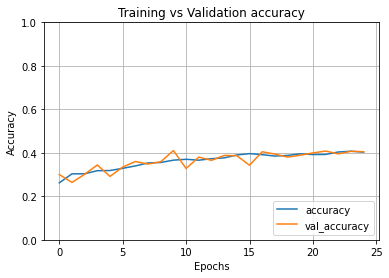

In [0]:
######### Graph - Training vs Validation accuracy per epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.grid(True)
plt.legend(loc='lower right')

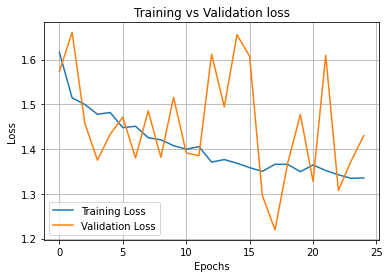

In [0]:
########## Graph - Training vs Validation loss per epoch
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title('Training vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='lower left')

In [0]:
####### Confusion Matrix #########

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


Y_pred = model.predict_generator(validation_generator, total_validation_file // bs+1)

y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


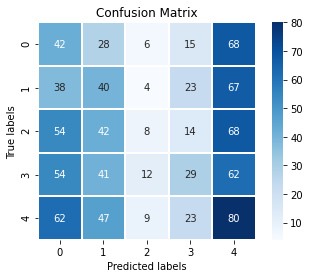

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, square = True, cmap="Blues" , linecolor= "white", linewidths= '1');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [0]:
class_labels = ['class_0', 'class_1', 'class_2','class_3','class_4']
clasy_rep= classification_report(validation_generator.classes, y_pred, target_names= class_labels)

print('Classification Report:\n')
print(clasy_rep)

Classification Report:

              precision    recall  f1-score   support

     class_0       0.17      0.26      0.21       159
     class_1       0.20      0.23      0.22       172
     class_2       0.21      0.04      0.07       186
     class_3       0.28      0.15      0.19       198
     class_4       0.23      0.36      0.28       221

    accuracy                           0.21       936
   macro avg       0.22      0.21      0.19       936
weighted avg       0.22      0.21      0.20       936

